Students: <b>Jonas WACKER</b> & <b>Sofiene JERBI</b><br>
Group: <b>user4</b>

Advances in imaging equipment and automation have led to an overabundance of data on the functioning of the brain. Technologies today can sample brain activity from a large number of neurons in a large region while organisms are actively behaving. For example, by simultaneously recording the electrical activity of every neuron of the mouse brain over an extended period of time, the amount of data generated will create completely new paradigms for biology, that will require the development of tools to extract value from such unprecedented amount of information.

In this Notebook, we use PySpark and the [Thunder project](https://github.com/thunder-project/thunder), which is developed on top of PySpark, for processing large amounts of time series data in general, and neuroimaging data in particular. We will use these tools for the task of understanding some of the structure of Zebrafish brains, which is a typical (and simple) example used in Neuroimaging. Using Thunder, we will cluster different regions of the brain (representing groups of neurons) to discover patterns of activity as the zebrafish behaves over time.

**Note**: Please, use the documentation for the [Thunder API](http://docs.thunder-project.org/) to learn the details of function calls!


# Goals

The main goals of this notebook are:

1. Learn about Thunder and how to use it
2. Revisit the K-Means algorithm and the method for choosing K
3. Learn alternative approaches to improve the results


# Steps
1. In section 1, we go though some background concepts that are used in this notebook.
2. Next, in section 2, we will get familiar with Thunder, its methods and its data types, by working on some simple tasks.
3. Finally, in section 3, we will build a model to cluster the neurons of a zebrafish based on their behavior. In this step, we will learn about how to use K-Means when the value of K is unknown. Finally, some tricks to improve the results are introduced.

# 1. Background concepts

In this section, we cover the terminology and the concepts that constitute the domain knowledge for this notebook.

As it should be well-known, a `pixel` is a combination of "**pic**ture **el**ement": digital images can be modeled as simple 2-dimensional (2D) matrices of intensity values, and each element in the matrix is a pixel. In color images, a pixel contains values of red, green, and blue channels. In a grayscale image, the three channels have the same value, such that each pixel is reduced to be a single value.

A single 2D image is not nearly enough to express 3D objects, which use a **voxel**, representing a value of the 3D image on a regular grid in a three-dimensional space.  A possible technique to work on 3D images is to acquire multiple 2D images of different slices (or `planes`, or `layers`) of a 3D object, and stack them one on top of each other (a z-stack). This ultimately produces a 3D matrix of intensity values, where each value represents a `volume element` or `voxel`.

![](https://upload.wikimedia.org/wikipedia/commons/b/b4/Voxelgitter.png)
<div style="text-align:center;">This z-stack image has 4 layers. A point is a voxel. It can be determined by the layer's index and the position in that layer.</div>

In the context of the Thunder package, we use term `image` for `3D-image` or `stack image`. Thunder uses `Image` type to  represent 3D-image. Each `Image` object is a collection of either 2D images or 3D volumes. In practice, it wraps an n-dimensional array, and supports either distributed operations via Spark or local operations via  numpy , with an identical API.

Stack-images can represent 3D objects, but it can be difficult to take the temporal relationship of the images into account. To do that, we need another data structure that shows the changes of voxels over time. In the Thunder package, the internal `Series` type can be used exactly for this purpose. Each `Series` is a 1D array such that each element is a value of the voxel at a timestamp.

The most common series data is time series data, in which case the index is time and each record is a different signal, like a channel or pixel.

We now have sufficient material to start playing with Thunder !!!

# 2. Let's play

Well, wait a second before we play... Remember, we're going to use Spark to perform some of the computations related to this Notebook. Now, when you spin a Zoe Notebook application (this comment is valid for students at Eurecom), you'll gain access to an individual, small Spark cluster that is dedicated to your Notebook. This cluster has two worker machines, each with 6 cores. As such, a good idea to obtain smooth performance and a balanced load on the workers, is to ```repartition``` your data (i.e., the RDDs you use to represent images or time series).

In this Notebook we **expect** students to take care of repartitioning, and such care will be compensated by bonus points.

## 2.1. Play with Image objects

### a. Loading image data

Both `images` and `series` can be loaded from a variety of data types and locations. You need to specify whether data should be loaded in 'local' mode, which is backed by a numpy array, or in 'spark' mode, which is backed by an RDD by using the optional argument `engine`. The argument `engine` can be either `None` for local use or a SparkContext for` distributed use with Spark.

```python
import thunder as td

# load data from tif images
data = td.images.fromtif('/path/to/tifs')

# load data from numpy-arrays
data = td.series.fromarray(somearray)
data_distributed = ts.series.fromarray(somearray, engine=sc)
```

We can load some example image data by:

In [1]:
import thunder as td
import numpy as np

# load some example image data
image_data = td.images.fromexample('fish', engine=sc)
image_data = image_data.repartition(12)

# print the number of images
print(image_data.count())

20


### b. Inspecting image data

Shape of the data: (20, 2, 76, 87)
Shape of the data of the first image: (2, 76, 87)
Data of the first image: [[[26 26 26 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  [26 26 26 ..., 27 27 26]
  ..., 
  [26 26 26 ..., 27 27 26]
  [26 26 26 ..., 27 26 26]
  [25 25 25 ..., 26 26 26]]

 [[25 25 25 ..., 26 26 26]
  [25 25 25 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  ..., 
  [26 26 26 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  [25 25 25 ..., 26 26 26]]]


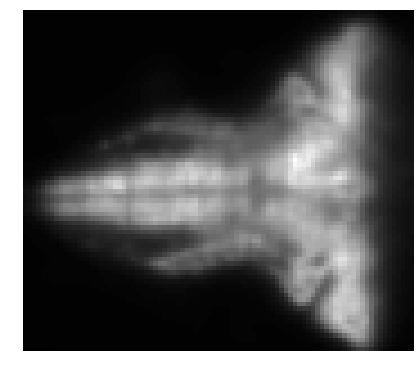

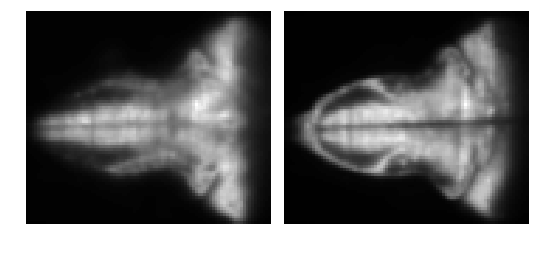

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# import two function to draw images easier
from showit import image as draw_image
from showit import tile as draw_tile

print("Shape of the data:", image_data.shape)

first_image = image_data.first() # get the values of Image object
# or first_image = image_data[0] # get the Image object

print("Shape of the data of the first image:", first_image.shape)

print("Data of the first image:", first_image)


# draw the first layer of the first image
draw_image(first_image[0])

# draw all layers of the first image
draw_tile(first_image)

# we can use index slices to take images
samples = image_data[0:6]



From the result above, the shape of the loaded data is (20, 2, 76, 87). It means we have total 20  3D images objects. Each image has 2 layers, each layer has size 76x87. 

Note that, although  data  is not itself an array (it can be a kind of RDD), we can index into it using bracket notation, and pass it as input to plotting methods that expect arrays. In these cases, the data will be automatically converted.

One of the advantages of working in Python is that we can easily visualize our data stored into Spark RDDs using the Matplotlib library. Function `draw_image` and `draw_tile` that take advantages of Matplotlib are examples.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 1

<div class="alert alert-info">  
a) Use the function `imgshow` from matplotlib to plot each layer of the first image in `image_data`.  

b) Discuss the choice of parameters you use for the method `imgshow`  

</div>

/opt/conda/lib/python3.5/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


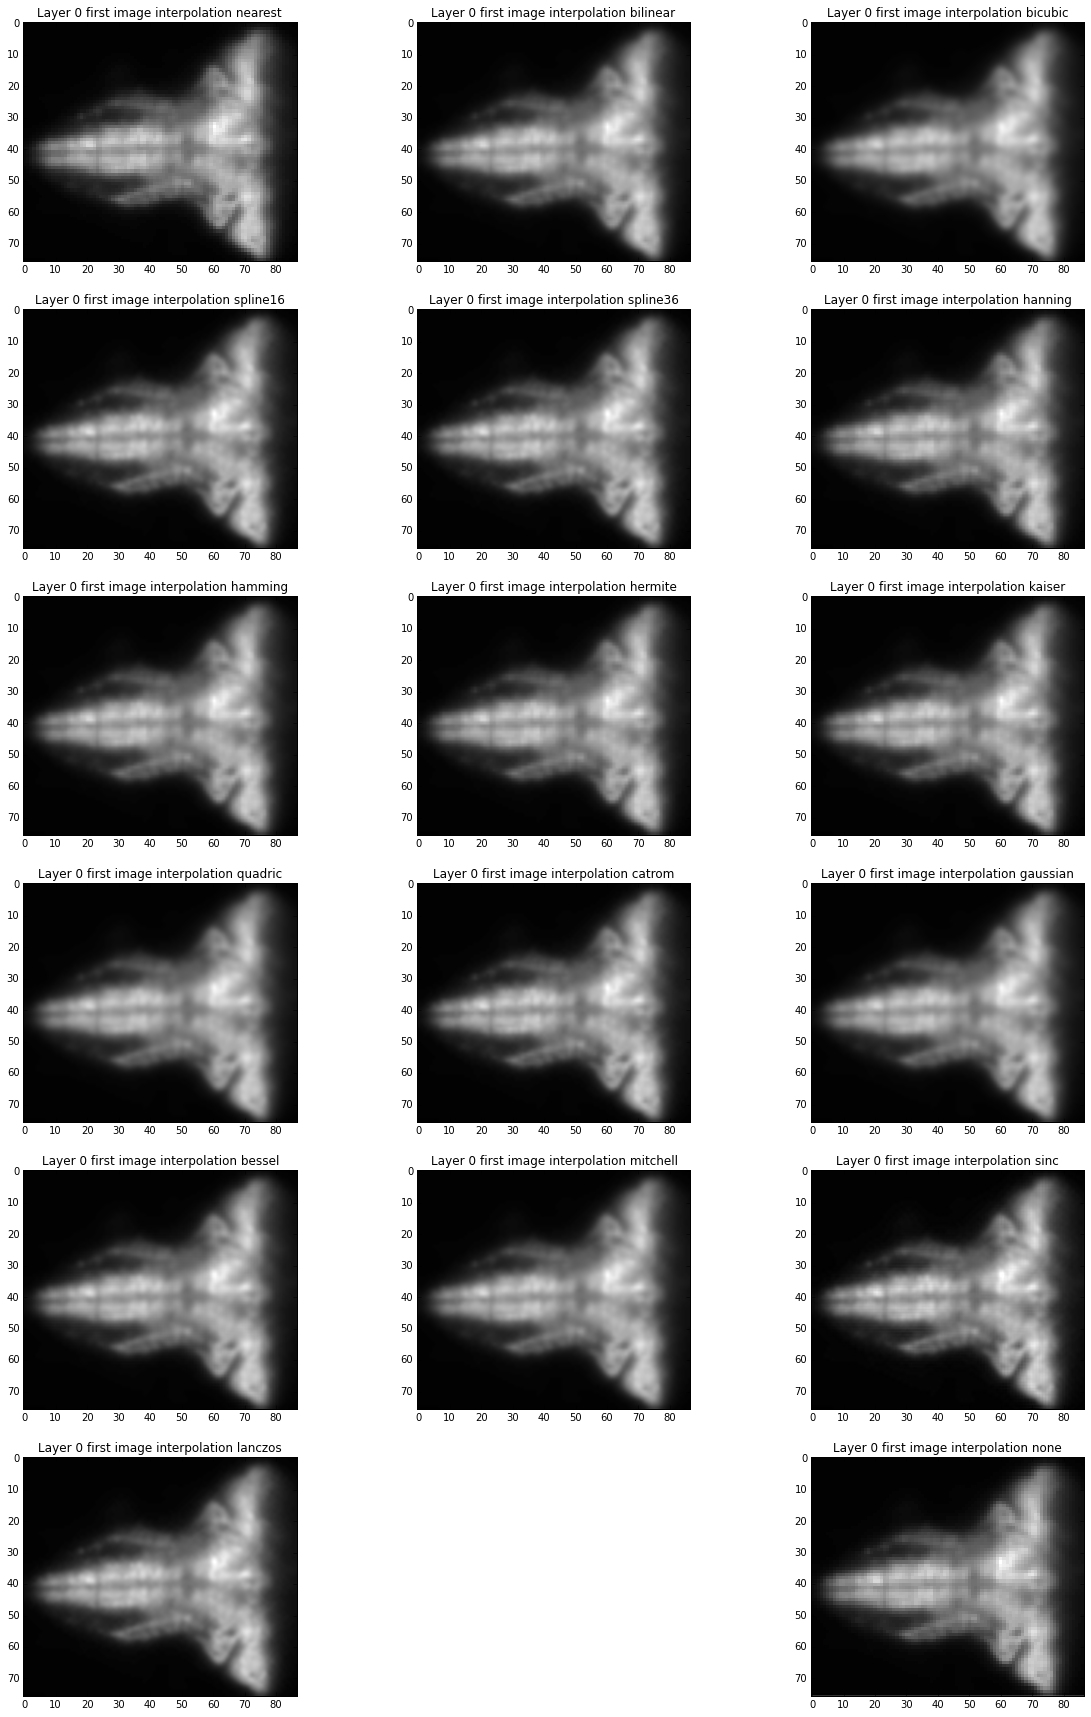

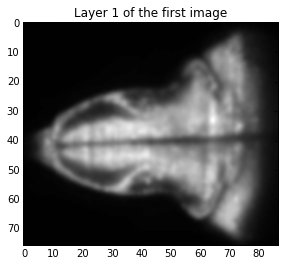

In [72]:
img = image_data.first() 
# or:
# img = image_data[1]

# show the first layer
plt.figure(1,figsize=(20, 30))
for i,interpolation in enumerate(['none', 'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']):
    plt.subplot(6,3,i)
    plt.imshow(img[0], interpolation=interpolation, aspect='equal', cmap='gray')
    plt.title("Layer 0 first image interpolation " + interpolation)
plt.show()

# show the second layer
plt.imshow(img[1], interpolation='spline36', aspect='equal', cmap='gray')
plt.title("Layer 1 of the first image")
plt.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


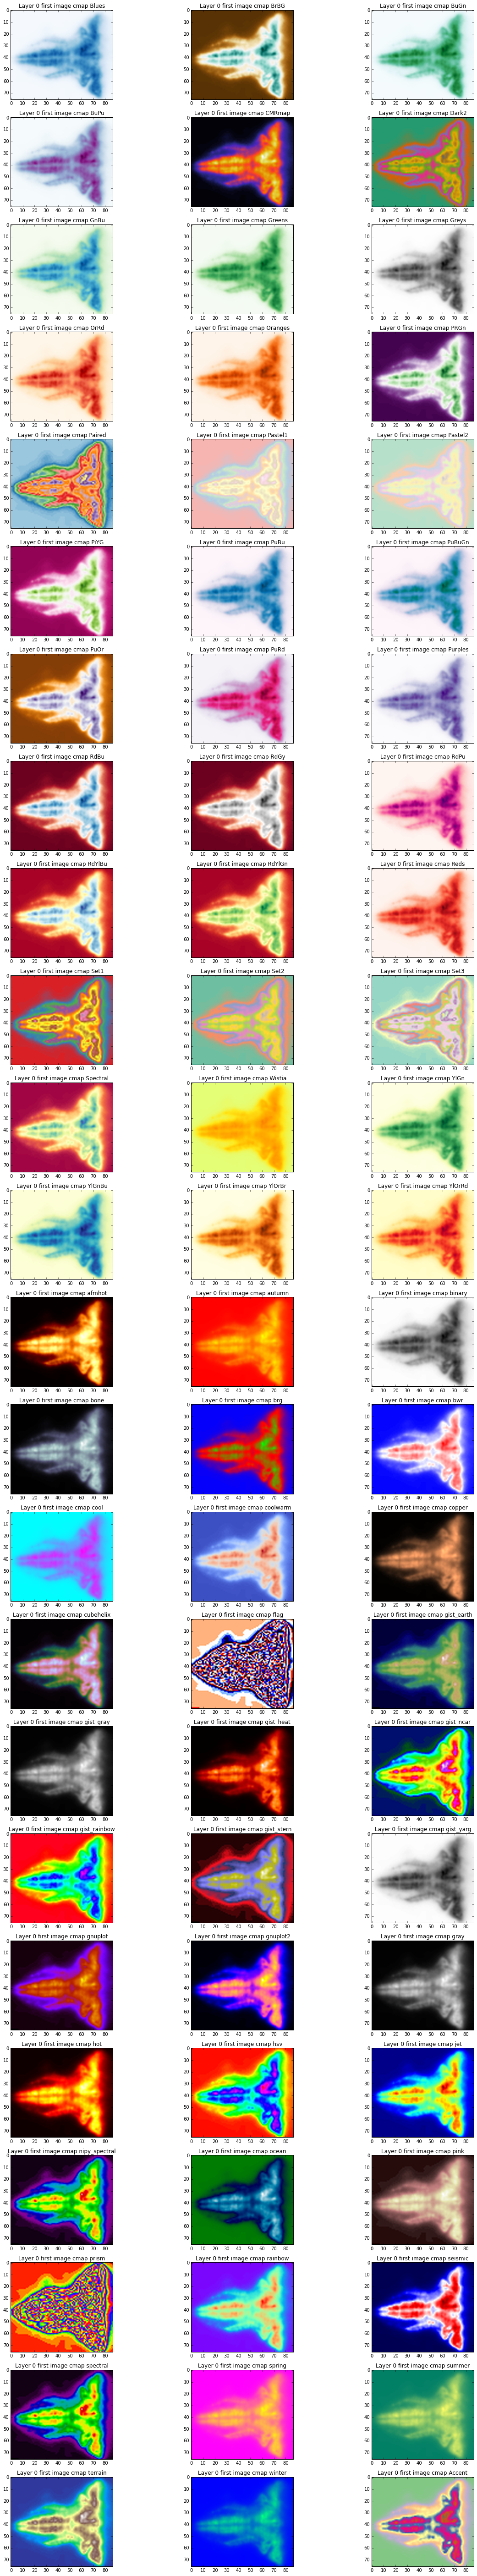

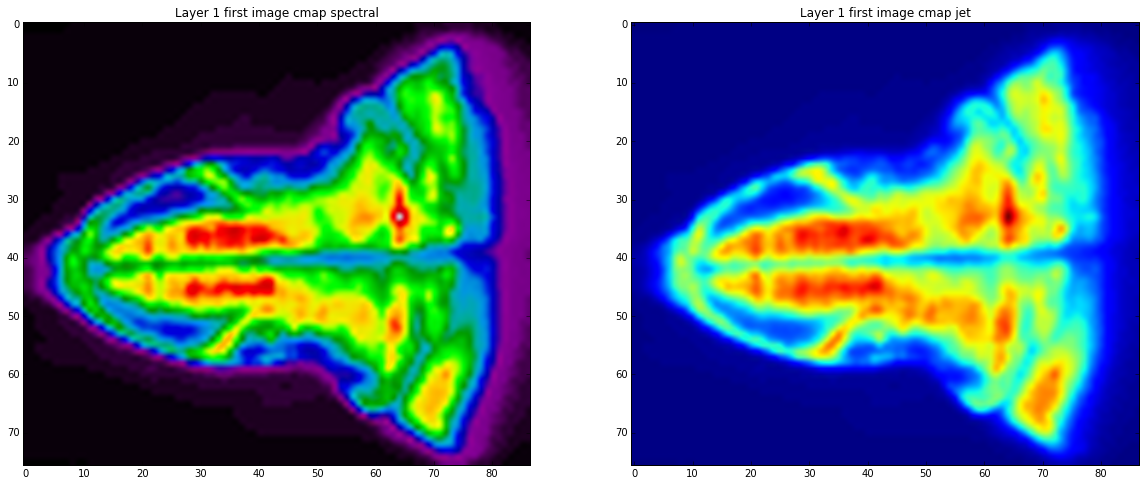

In [20]:
img = image_data.first()
maps = sorted(m for m in plt.cm.datad if not m.endswith("_r"))

fig = plt.figure(figsize=(20,100))
for i,m in enumerate(maps):
    plt.subplot(24,3,i)
    plt.imshow(img[0], interpolation='spline36', aspect='equal', cmap=plt.get_cmap(m))
    plt.title("Layer 0 first image cmap " + m)
plt.show()

# show the second layer
fig = plt.figure(figsize=(20,10))
plt.subplot(1,2,0)
plt.imshow(img[1], interpolation='spline36', aspect='equal', cmap='jet')
plt.title("Layer 1 first image cmap jet")
plt.subplot(1,2,1)
plt.imshow(img[1], interpolation='spline36', aspect='equal', cmap='spectral')
plt.title("Layer 1 first image cmap spectral")
plt.show()

<div class="alert alert-warning">

We pass the following parameters to the imshow function:<br />
interpolation, aspect and cmap.<br />
The cmap parameter applies a color scheme to the intensity values of each pixel. cmap='gray' simply means that high intensities are represented by a higher brightness value (from black to white). cmap='jet' for example would apply warmer colors to higher values and colder colors to lower ones.<br />
aspect='equal' means that the displayed image is resized s.t. it has equal width and height. The original size was (76, 87).<br />
The interpolation parameter determines the interpolation technique used for filling up empty pixel values when upscaling the image. We compared all the available interpolation techniques and find that interpolation='spline36' exhibits more details while smoothing out the image nicely.

</div>

Then, we can perform operations that aggregate information across images.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 2
<div class="alert alert-info">

Calculate the standard deviation across all images you have in `image_data` (that is, our dataset). To clarify, let's focus on an individual layer (say the first layer of each image). For every `voxel`, compute the standard deviation of its values across different images for the same layer. Visualize the standard deviation you obtain, for example concerning a single layer (as before, say the first layer).

</div>

<div class="label label-success">HINT 1</div> to avoid wasting time and energy, make sure you lookup for methods that could help answer the question from the Thunder documentation.  

<div class="label label-success">HINT 2</div> We can also use function `draw_image(<data>)` to plot an image in a simple way instead of using many statements with matplotlib as before.

<div class="label label-danger">NOTE</div> Comment the image you obtain. What does it mean to display the standard deviation across all images in a single layer?

([<matplotlib.image.AxesImage at 0x7f3b404e29e8>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f3b49e11e10>)

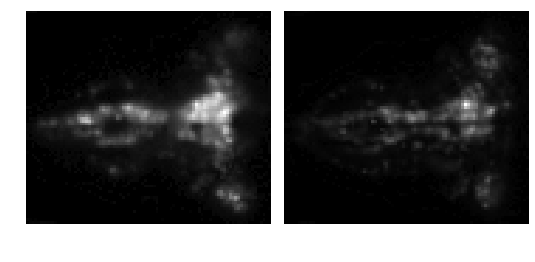

In [3]:
# calculate standard deviation of images
std_imgs = image_data.std()
draw_tile(std_imgs)

<div class="alert alert-warning">

We compute the standard deviation for each pixel inside each layer over all 20 sample images. Bright values correspond to a high standard deviation. On the resulting images we can see that there seems to be more activity in the right part of the fish's brain images. Since the images describe the neuronal activiy, we could assume that when the samples were taken the fish mainly used the right part of its brain.

</div>

### c. Selecting samples of image data

The Images API offers useful methods for working with large image data. For example, in some cases it is necessary to subsample each image, to make sure we can analyze it efficiently.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 3

<div class="alert alert-info">  
The source code below subsamples image data with different ratios on different dimensions.   

a) Complete the source code to plot the first layer of the first image.   

b) What is the shape of `image_data` before and after subsampling?  

</div>

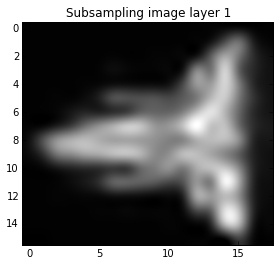

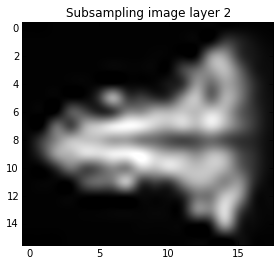

Before subsampling: (20, 2, 76, 87)
After subsampling: (20, 2, 16, 18)


In [7]:
subsampled = image_data.subsample((1, 5, 5))
# Stride to use in subsampling. If a single int is passed, each dimension of the image
# will be downsampled by this same factor. If a tuple is passed, it must have the same
# dimensionality of the image. The strides given in a passed tuple will be applied to
# each image dimension
plt.imshow(subsampled.first()[0], interpolation='spline36', aspect='equal', cmap='gray')
plt.title("Subsampling image layer 1")
plt.show()
plt.imshow(subsampled.first()[1], interpolation='spline36', aspect='equal', cmap='gray')
plt.title("Subsampling image layer 2")
plt.show()
print("Before subsampling:", image_data.shape)
print("After subsampling:", subsampled.shape)

<div class="alert alert-warning">

We subsampled each image in image data by a ratio of 5 meaning that for every square of 25 (5x5) pixels we extracted one representative pixel. This reduces the original images of size (76, 87) to (16, 18), where we preserved both layers for each image (76/5 ~ 16 and 87/5 ~ 18).<br />


?? (The 20 is wrong, actually just 1 image.)

</div>

Note that `subsample` is an RDD operation, so it returns immediately. Indeed, we know that in Spark you must apply a RDD action to trigger the actual computation.

### d. Converting image data
We can also convert an RDD of images to a RDD of series by:

In [2]:
seriesRDD = image_data.toseries()
seriesRDD = seriesRDD.repartition(12).cache()

In [3]:
print(seriesRDD.shape)

(2, 76, 87, 20)


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 4
<div class="alert alert-info">
According to your understanding about `Series` objects which was introduced in section 1, what is the shape of `seriesRDD` and its elments ?  

Comment your results, don't just display numbers.
</div>

<div class="alert alert-warning">

Shape (2, 76, 87, 20) because one Series for each pixel of 3D-image that is a 1D-array of its values in different timestamps. (2, 76, 87) is actually the dimension of the 3-D image (2 layers, 76 height and 87 width) and 20 the number of timestamps, so 2\*76\*87=13224 1-D arrays of length 20.

</div>

For a large data set that will be analyzed repeatedly as a `Series`, it will ultimately be faster and more convienient to save `Images` data to a collection of flat binary files on a distributed file system, which can in turn be read back in directly as a `Series`, rather than repeatedly converting the images to a `Series` object. This can be performed either through a ThunderContext method, `convertImagesToSeries`, or directly on an Images object, as done below:

In [106]:
seriesRDD.tolocal().tobinary('directory', overwrite=True)
ts = td.series.frombinary('directory', engine=sc)

We will study about `Series` object in the next section.

## 2.2. Play with Series objects

### a. Loading Series data

In this section, we use a sample data to explore `Series` objects.

In [3]:
#series_data = td.series.fromexample('fish', engine=sc)
#series_data = td.series.frombinary('directory', engine=sc)
series_data = image_data.toseries()

### b. Inspecting Series data

`Series_data` is a distributed collection of key-value records, each containing a coordinate identifier and the time series of a single `voxel`. We can look at the first record by using `first()`. It’s a key-value pair, where the key is a tuple of `int` (representing a spatial coordinate within the imaging volume) and the value is an one-dimensional array.

In [6]:
first_series = series_data.first() # get the values of Series object
#first_series = series_data[0] # get a Series object

print("Shape of series:", series_data.shape)
print("The first series:", first_series)
print("Each element in series has", len(first_series), "values")

# print the 10th value of voxel (0,0,0)
# layer = 0
# coordinator = (0,0) in that layer
print("value 10th of voxel (0,0,0):", np.array(series_data[0,0,0,9]))

Shape of series: (2, 76, 87, 20)
The first series: [26 26 26 26 26 26 26 25 26 25 25 25 26 26 26 26 26 26 26 26]
Each element in series has 20 values
value 10th of voxel (0,0,0): 25


The loaded series data is a multi-dimensional array. We can access the values of a voxel in time series by using a tuple as above. In our data, each voxel has 20 values corresponding to 20 states at 20 different times.

### c. Selecting Series data
Series objects have a 1D index, which can be used to subselect values.

In [7]:
print("shape of index:", series_data.index.shape)
print("the first element of a subset", series_data.between(0,8).first())

shape of index: (20,)
the first element of a subset [26 26 26 26 26 26 26 25]


In [7]:
series_data.between(0,8).shape

(2, 76, 87, 8)

Values can be selected based on their index:

In [8]:
print(series_data.select(lambda x: x > 3 and x < 8).index)
print(series_data.select(lambda x: x > 3 and x < 8).first())

[4, 5, 6, 7]
[26 26 26 25]


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 5
<div class="alert alert-info">

Plot the first 20 values of **all** series objects (that is the values of a voxel) in the series data. This means, on the same plot, you should visualize the values each voxel takes in the first 20 time intervals.

</div>

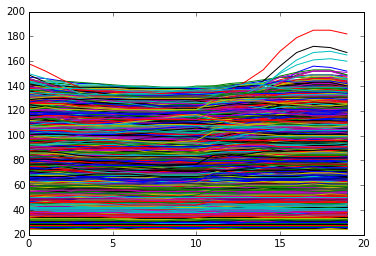

In [6]:
import numpy as np

series_data_rdd = series_data.tordd().repartition(12)
# only select the first 20 states of each object
samples = series_data_rdd.values().collect()
#samples = series_data.between(0,20).tordd().values().collect()

plt.plot(np.array(samples).T)
plt.show()

In [20]:
len(samples)

13224

In [22]:
len(samples[0])

20

<div class="alert alert-warning">
We can see that a few voxels behave differently from the rest, i.e. most lines have the same shape while a few have a strong bend in the end. E.g. the red, brown and turquoise line pop out on top of the rest of the plot between images 13-20. We also see some variation from picture 11 to 15.
</div>

Now, another objective we can have is to select specific series objects within the same series data. For example, we can select objects randomly by using function `sample`.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 6

<div class="alert alert-info">

Let's plot a random subset of the data using the method `sample`.  

Complete the source code below to plot the first 20 values of 30 objects that are selected randomly among those that pass the condition on the standard deviation, using function `sample`.

</div>

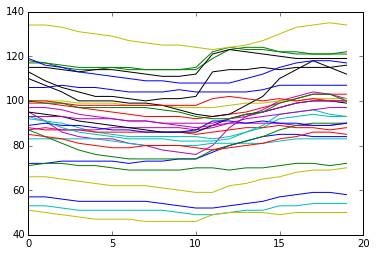

In [25]:
# select 30 objects randomly which have standard deviation > threshold
# Extract random subset of records, filtering on a summary statistic.
examples = series_data.filter(lambda x: x.std() > 1.0).sample(30)
# only plot first 20 states of each object
plt.plot(np.array(examples).T)
plt.show()

In [26]:
type(series_data)

thunder.series.series.Series

### d. Preprocessing Series data
A `Series` objects has some methods which can be useful in an eventual preprocessing phase.

For example,`center` subtracts the mean, `normalize` subtracts and divides by a baseline (either the mean, or a percentile).

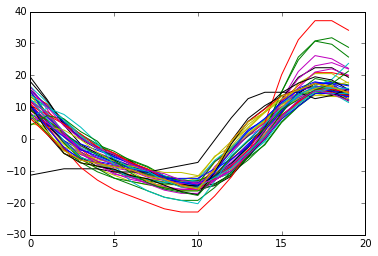

In [99]:
examples = series_data.center().filter(lambda x: x.std() >= 10).sample(50)
plt.plot(np.array(examples).T)
plt.show()

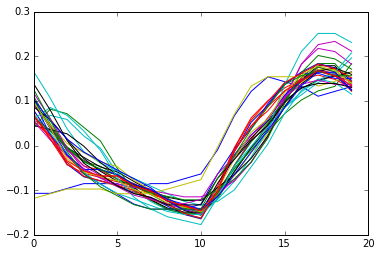

In [10]:
normalizedRDD = series_data.normalize(method='mean').filter(lambda x: x.std() >= 0.1).sample(50)
plt.plot(np.array(normalizedRDD).T)
plt.show()

### e. Computing statistics about Series data
A `Series` can be summarized with statistics both within and across images. To summarize **across records** (the statistic of all voxels at each timestamp), we can do the following:

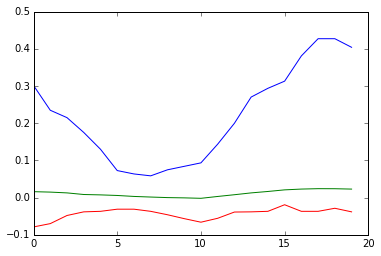

In [101]:
plt.plot(series_data.normalize().max());
plt.plot(series_data.normalize().mean());
plt.plot(series_data.normalize().min());

To summarize **within records**, we can use the `map` method:

In [11]:
means = series_data.map(lambda x: x.mean())
flat_means = means.flatten().toarray()
flat_stdevs = stdevs = series_data.map(lambda x: x.std()).flatten().toarray()
print("means:", flat_means)
print("length of means:", len(flat_means))
print("mean of the first series:", flat_means[0])
print("standard deviation of the first series:", flat_stdevs[0])

means: [ 25.8   25.85  25.7  ...,  26.    26.    26.  ]
length of means: 13224
mean of the first series: 25.8
standard deviation of the first series: 0.4


`means` is now a `Series` object, where the value of each record is the mean across the time series for that voxel.

Note that in the source code above, we use function `toarray` to return all records to the driver as a numpy array.

For this `Series`, since the keys correspond to spatial coordinates, we can `pack` the results back into a local array in **driver node**.


To look at this array as an image, we can use function `draw_image` as before.

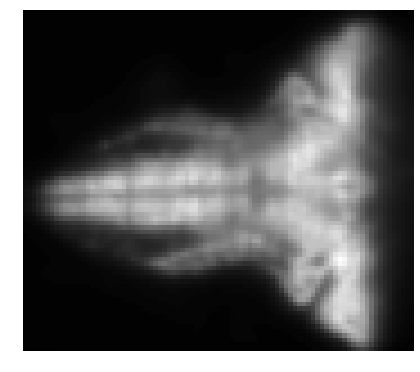

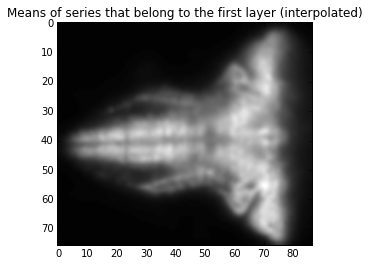

In [12]:
# we should recover the shape of means before plotting
# draw the standard deviations of series that belong to the first layer
image = flat_means.reshape((2, 76, 87)) [0,:,:]
draw_image(image)
plt.figure(2)
plt.imshow(image, interpolation='spline36', aspect='equal', cmap='gray')
plt.title("Means of series that belong to the first layer (interpolated)")
plt.show()

Note that `toarray` is an example of a local operation, meaning that all the data involved will be sent to the Spark driver node. In this case, packing the mean is no problem because its size is quite small. But for larger data sets, this can be **very problematic**. So, it's a good idea to downsample, subselect, or otherwise reduce the size of your data before attempting to pack large image data sets! 

### f. Identifying correlations

In several problem domains, it may also be beneficial to assess the similarity between a designated signal (time series) and another signal of interest by measuring their correlation. For example, say we have two time series corresponding to the consumption of Coca Cola and Pepsi, it would perhaps be interesting to verify whether behavioural patterns are similar for both brands over time.<br>

Simply as a proof of concept, we shall compare our data to a random signal and we expect that, for a random signal, the correlation should be low. The signal can be stored as a numpy array or a MAT file containing the signal as a variable. Note that the size of the signal must be equal to the size of each `Series` element.

In [108]:
from numpy import random
signal = random.randn(len(first_series))
print("The correlation of the first element with random signal:" , series_data.correlate(signal).first())

first_element = series_data.first()
corr = series_data.correlate(np.array(first_element)).first()
print("The correlation of the first element with itselft:", corr)

The correlation of the first element with random signal: [ 0.21125507]
The correlation of the first element with itselft: [ 1.]


# 3. Usecase

## 3.1. Context
Neurons have a variety of biochemical and anatomical properties. Classification methods are thus needed for clarification of the functions of neural circuits as well as for regenerative medicine. In this usecase, we want to categorize the neurons in a fish brain, based on their behavior. The behavior of a neuron can be expressed by the change of its states. The activies of the brains are captured over time into images.

Neurons have a variety of biochemical and anatomical properties. Classification methods are thus needed for clarification of the functions of neural circuits as well as for regenerative medicine. In this usecase, we want to categorize the neurons in a fish brain, based on their behavior. The behavior of a neuron can be expressed by the change of its states. The activies of the brains are captured over time into images.

In this notebook,  we use K-Means, a well known clustering algorithm which is also familiar to you, as it was introduced during the last lecture on anomaly detection.

## 3.2 Data
The dataset we will use is the time series data which we played with in the previous section. Refer to section 2 if you want to duplicate the code to load such data.

## 3.3.  Building model
### a. Importing required modules

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from pyspark.mllib.clustering import KMeans, KMeansModel
from matplotlib.colors import ListedColormap

### b. Loading & inspecting the data

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 7
<div class="alert alert-info">

Load example series data from `fish`, then normalize and cache it to speed up repeated queries. Print the dimensional information of the loaded data.

</div>

In [4]:
# we must normalize it to get best clustering
#data = td.series.fromexample('fish', engine=sc).normalize()
data = td.images.fromexample('fish', engine=sc).toseries().normalize()

# cache it to speed up related queries
data.cache()

# check the dimensions of data
print (data.shape)

(2, 76, 87, 20)


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 8
<div class="alert alert-info">
When studying the properties of large data set, we often take a small fraction of it. We have many strategies to select this subset, such as selecting randomly, selecting elements that has the standard deviation bigger than a threshold, or mixing the conditions.  

In this notebook, we will use the second method as a small demonstration.

<ul></ul>

In order to choose a good value for the threshold of standard deviation, we should compute the stddev of each series and plot a histogram of a 10% sample of the values.

<ul></ul>

Complete the source code below to compute the standard deviation of series in data. Plot the histogram of it and discuss it in details. In your opinion, what should be the best value for the threshold ?

</div>

In [9]:
num_datapoints = data.count()
num_samples = int(0.1 * num_datapoints)

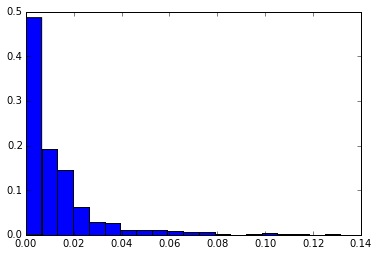

In [10]:
# calculate the standard deviation of each series
# then select randomly 10% of value to plot the histogram


stddevs = (data
           .map(lambda x: x.std())
           .sample(num_samples)
           .flatten().toarray()
          )

# plot the histogram of 20 bins
weights = np.ones_like(stddevs)/float(len(stddevs))
plt.hist(stddevs, 20, weights=weights)
plt.show()

<div class="alert alert-warning">

We want to take a fraction of the data. Let 20% be that fraction. We see that values with std&lt;0.02 take 45+20+15=80% of the data (actually of the sample). So putting the threshold at 0.02 will only make us keep about 20% of the data. Setting the threshold is a crucial decision because we filter s.t. only neurons with a minimum amount of activity are kept. We therefore assume that all the other regions of the image are not of interest to subsequent analysis (because they might be erroneous image fragments due to measurement mistakes etc.). Setting a decent threshold requires domain knowledge.

</div>

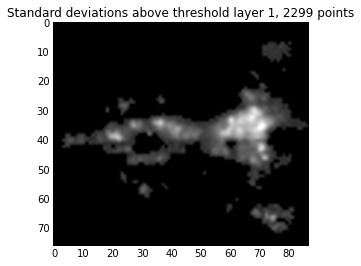

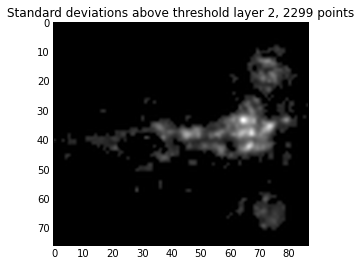

In [11]:
threshold = 0.02

def threshold_mask(value):
    return value if value>=threshold else 0
    

all_stdevs = data.map(lambda x: x.std()).map(threshold_mask).flatten().toarray()

first_layer = all_stdevs.reshape((2, 76, 87)) [0,:,:]
second_layer = all_stdevs.reshape((2, 76, 87)) [1,:,:]
num_filtered = len(all_stdevs[np.where(all_stdevs > 0.0)])

plt.figure()
plt.imshow(first_layer, interpolation='spline36', aspect='equal', cmap='gray')
plt.title("Standard deviations above threshold layer 1, " + str(num_filtered) + " points")
plt.show()
plt.imshow(second_layer, interpolation='spline36', aspect='equal', cmap='gray')
plt.title("Standard deviations above threshold layer 2, " + str(num_filtered) + " points")
plt.show()

<div class="alert alert-warning">
Looking at the histogram as well as at the thresholded brain activity plot, a standard deviation of 0.02 seems to be a good threshold to filter image regions having a high brain activity. However, the value is still very arbitrary since we do not have any domain knowledge. For example it could also be that we should only filter out parts that do not capture actual brain activity because of e.g. erroneous measurements. For now we only work with intuitive results.
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 9

<div class="alert alert-info">

Extract some samples just to look at the typical structure of the time series data.
The objects are selected randomly, and has the standard deviation bigger than the threshold which you picked in question 8.
Plot the samples and discuss your obtained figure.

</div>

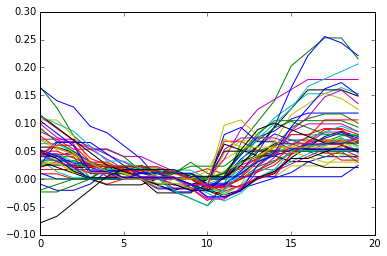

In [16]:
# sample 50 objects of the data randomly base on the standard deviation
examples = data.filter(lambda x: x.std()>=0.02).sample(50)

# plot the sample data
plt.plot(np.array(examples).T)
plt.show()

In [17]:
total_min = np.min(data.min().toarray())
print(total_min)

-0.078853046595


<div class="alert alert-warning">

For the extracted series above a threshold std. dev. of 0.02, we see that this data has the biggest variation along the first and the last few timestamps. The values between the third and the 10th timestamp seem to be quite steadily centered around 0, which corresponds to almost no activity (close to the total minimum value). This means that when picking the most variying voxels, only the timestamps outside that range show any activity to be analysed.

</div>

### c. Clustering series
In this section, we will use K-means to cluster the series. In other words, we cluster the voxels based on the their behavior. Currently, we have no clue about how many groups `K` of neural behavior. To this end, instead of choosing a single value K, we use multiple values, build model with each `K` and compare the resulting error values. After that, we can choose the best value of `K`. 

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 10

<div class="alert alert-info">

Complete the source below to build multiple models coresponding to multiple values of `K` using algorithm KMeans of MLLib.  

a) Comment the structure of the code. Precisely, focus on the `for` loop, and state what is parallel and what is not.  

b) Can you modify the structure of the code such that you use the most of the parallelization capabilities of Spark?  
</div>

In [44]:
import time

# declare the possible values of K
ks = [5, 10, 15, 20, 30, 50, 100, 200]

# convert series data to rdd of values
training_data = data.tordd().map(lambda x: np.array(x[1])).cache()
    
def buildModels(data):
    # declare the collection of models
    models = [] 

    # build model for each K and append to models
    for k in ks:
        models.append(KMeans.train(training_data, k, maxIterations=10, initializationMode="k-means||")) 
    return models

time0 = time.time()
models = buildModels(training_data)
print(time.time() - time0, "seconds")

10.205661296844482 seconds


In [35]:
from sklearn.cluster import KMeans as KMeansSK

ks_rdd = sc.parallelize([5, 10, 15, 20, 30, 50, 100, 200])

# convert series data to rdd of values
training_data = data.tordd().map(lambda x: np.array(x[1])).cache()
    
def buildModels2(data):
    # declare the collection of models
    bData = sc.broadcast(data.collect())
    
    models = ks_rdd.map(lambda k: KMeansSK(k, init='k-means++', max_iter=10).fit(bData.value))
    #models = ks_rdd.map(lambda k: KMeans.train(bData, k, maxIterations=10, initializationMode="k-means||"))

    return models.collect()

time0 = time.time()
models_sk = buildModels2(training_data)
print(time.time() - time0, "seconds")

6.561760663986206 seconds


In [64]:
print('Sample length:', len(training_data.first()))

Sample length: 20


In [63]:
print('Sample count: ', training_data.count())

Sample count:  13224


<div class="alert alert-warning">

<p>a) In general, we convert the whole dataset into an RDD making sure it is distributed among the spark worker instances. This way we make sure that the mllib K-means algorithm can work on the dataset in parallel (assignment and update steps).
Building the different models inside the for loop however, is done sequentially!</p>
<p>b) If we want to parallelize the training over different model instances, we have to choose another approach since the training of k-Means takes place on several machines in spark already. Therefore, we cannot run different k-Means instances on different machines (each instance needs to operate on the entire distributed dataset). A solution is to copy the whole data to each worker machine and to run a local k-Means instance on each worker. This is possible because our dataset has only 13224x20 values. Doing it this way we have a performance gain of around 30%.</p>

</div>

### d. Testing models & choosing the best one

Next, we evaluate the quality of each model. We use two different error metrics on each of the clusterings. 

* The first is the sum across all time series of the Euclidean distance from the time series to their cluster centroids. 

* The second is a built-in metric of the `KMeansModel` object.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 11

<div class="alert alert-info">  

a) Write function `model_error_1` to calculate the sum of Squared Euclidean Distance from the Series objects to their clusters centroids.  

b) Comment the choice of the error function we use here. Is it a good error definition?

</div>

In [14]:
from scipy.spatial.distance import euclidean

# calculate the Euclidean distance
# from each time series to its cluster center
# and sum all distances
def model_error_1(data, model):
    return data.map(lambda x: euclidean(x,model.centers[model.predict(x)])).reduce(lambda x,y: x+y)

print(model_error_1(training_data,models[0]))

531.3194146912344


<div class="alert alert-warning">

We are computing the "Within Set Sum of Squared Error" (WSSSE) of the clustering. The metric measures the coherence within the clusters by penalizing datapoints that are far away from the corresponding centers strongly (squared differences). Despite the measure being quite common in cluster evaluation, we can also compute Silhouette values (https://en.wikipedia.org/wiki/Silhouette_(clustering)) that take the seperation among clusters into account. Then clusters do not only need to be coherent but they need to be well distinguishable. Apart from that we should also look at the distribution of datapoints among the clusters, i.e. how many datapoints belong to each cluster?

</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 12
<div class="alert alert-info">

a) Write function `model_error_2` to calculate the total of similarity of `Series` objects based on how well they match the cluster they belong to, and then calculate the error by inverse the total similarity.  

b) Similarly to the previous question, comment the choice of the similarity function.  

</div>

In [15]:
# calculate the total of similarity of the model on timeseries objects
# and calculate the error by inverse the total similarity
from scipy.spatial.distance import cdist

# Estimate similarity between a data point and the cluster it belongs to.
def similarity(p, centers):
    if np.std(p) == 0:
        return 0
    return np.corrcoef(centers[np.argmin(cdist(centers, np.array([p])))], p)[0, 1]


def model_error_2(data, model):
    return 1. / data.map(lambda x: similarity(x,model.centers)).reduce(lambda x,y: x+y)

print(model_error_2(training_data,models[0]))

0.000223231015077


<div class="alert alert-warning">

Similarly to the model_error_1 function we only take cluster coherence into account. The major difference is that this time we do not penalize distant points by squaring their distances. The dissimilarity is simply added.

</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 13
<div class="alert alert-info">

Plot the error of the models along with the different values of K in term of different error metrics above. From the figure, in your opinion, what is the best value for `K` ? Why ?

</div>

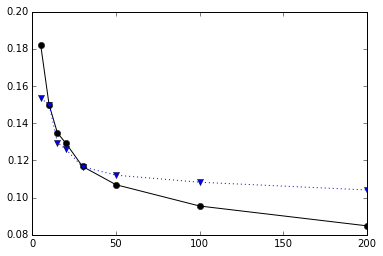

37.019800901412964 seconds


In [50]:
def testAndPlotTheResult(data, models):
    # compute the error metrics for the different resulting clusterings
    
    # errors of models when using function Sum Square Distance Error
    errors_1 = np.asarray([model_error_1(data,model) for model in models])
    
    # error of models when using similarity
    errors_2 = np.asarray([model_error_2(data,model) for model in models])

    # plot the errors with each value of K
    plt.plot(
        ks, errors_1 / errors_1.sum(), 'k-o',
        ks, errors_2 / errors_2.sum(), 'b:v')
    plt.show()

time0 = time.time()
testAndPlotTheResult(training_data, models)
print(time.time() - time0, "seconds")

<div class="alert alert-warning">

By only looking at the plot, k=30 seems a good choice. Until then the decrease in errors is quite irregular and makes bigger steps than later (we choose the "elbow"). We do not pick a higher value because of the issues stated below.

</div>

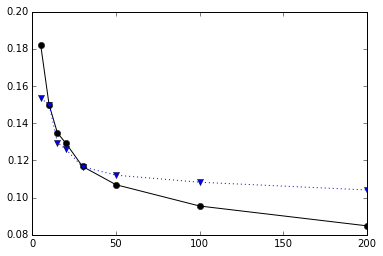

13.471877098083496 seconds


In [49]:
def model_error_1Parall(bData, model):
    err = 0
    for x in bData.value:
        err += euclidean(x,model.centers[model.predict(x)])
    return err

def model_error_2Parall(bData, model):
    err = 0
    for x in bData.value:
        err += similarity(x,model.centers)
    return 1. / err

def testAndPlotTheResultParall(data, models):
    # compute the error metrics for the different resulting clusterings
    
    bData = sc.broadcast(data.collect())
    # errors of models when using function Sum Square Distance Error
    errors_1 = np.asarray(models.map(lambda model: model_error_1Parall(bData,model)).collect())
    
    # error of models when using similarity
    errors_2 = np.asarray(models.map(lambda model: model_error_2Parall(bData,model)).collect())

    # plot the errors with each value of K
    plt.plot(
        ks, errors_1 / errors_1.sum(), 'k-o',
        ks, errors_2 / errors_2.sum(), 'b:v')
    plt.show()

modelsRDD = sc.parallelize(models)
time0 = time.time()
testAndPlotTheResultParall(training_data, modelsRDD)
print(time.time() - time0, "seconds")

<div class="alert alert-warning">

As we did for the parallelization of the execution of KMeans on different values of k, we can also parallelize the process of computing errors.
For that all we need to do is to broadcast the data and distribute  the computation of the error.
This way we get a significative gain in computation time.

</div>

Determining the optimal $k$ is particularly troublesome for the $k$-Means algorithm because error measures based on distance decrease monotonically as $k$ increases. This arises because when $k$ is increased, each cluster is decomposed into more and more clusters, such that each point becomes closer to its cluster mean. In fact, in the extreme case where $k=N$, each point will be assigned to its own cluster, and all distances are reduced to nil. Cross-validation or using holdout data is also unlikely to be particularly effective in this case.<br>

To this end, it is often worth assessing a model by measuring its impact on the overall aim of carrying out the clustering. For example, if we are carrying out $k$-means for grouping customers having similar taste and purchase history with the ultimate intent of making recommendations to customers, our objective function should measure how effective the recommendations are (perhaps using holdout data). An appealing aspect of using such a metric is that it is no longer guaranteed to behave monotonically with respect to $k$. We shall investigate this further in Question 20.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 14
<div class="alert alert-info">

Plot the centroids of the best model. Do you think that the result is good ?

</div>

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


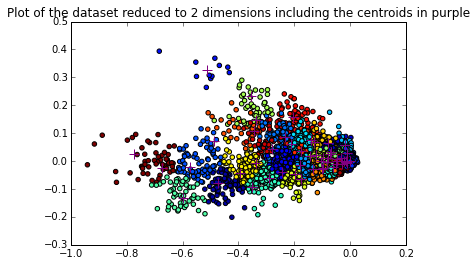

In [25]:
from pyspark.mllib.feature import PCA as PCAmllib
from pyspark.mllib.linalg import Vectors

# plot the best performing model
bestModel = models[4]

data_dense = training_data.map(Vectors.dense)

PCA_model = PCAmllib(2).fit(data_dense)
transformed = PCA_model.transform(data_dense)

features_2d = np.array(transformed.map(lambda x: np.array([x[0], x[1]])).collect())
centers_2d = np.array(PCA_model.transform(sc.parallelize(models[5].centers)).map(lambda x: np.array([x[0], x[1]])).collect())

cluster_labels = bestModel.predict(data_dense).collect()

plt.scatter(features_2d[:,0], features_2d[:,1], c=cluster_labels[:])
plt.scatter(centers_2d[:, 0], centers_2d[:,1], marker='+', s=100, c='purple')
plt.title('Plot of the dataset reduced to 2 dimensions including the centroids in purple')
plt.show()

<div class="alert alert-warning">

The clustering worked out well in general. However, it might be that our clusters have too much granularity. Reducing k might make more sense depending on the actual usage scenario. We still have to understand the domain better in oder to judge the clustering. Then the evaluation depends on the task at hand (do we want to determine outliers? do we want to classify images? do we want to quantize pixel values?)

</div>

### e. Visualizing the result
We can also plot an image of labels of neurons, such that we can visualize the group of each neuron.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 15

<div class="alert alert-info">

Complete the source code below to visualize the result of clustering.

</div>

In [35]:
bestModel = models[4]

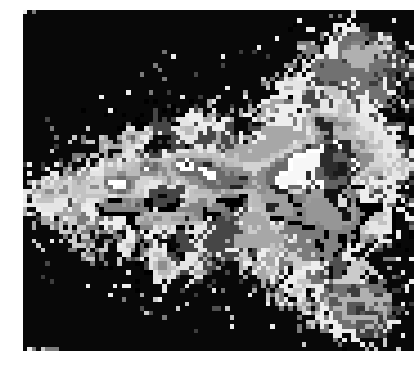

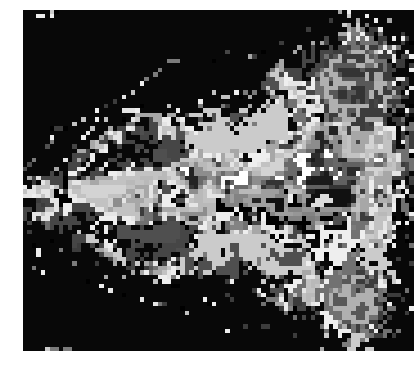

In [36]:
# predict the nearest cluster id for each voxel in Series
labels = bestModel.predict(training_data)

# collect data to the driver
imgLabels = np.array(labels.collect()).reshape((2, 76, 87))

# consider the voxel of the first layer
draw_image(imgLabels[0,:,:])

# consider the voxel of the second layer
draw_image(imgLabels[1,:,:])

With the default color scheme, this figure is quite difficult to understand and to distinguish the groups according to their similar colors. So, we should have a smarter color selection. The fact is, when we do clustering, it is often the case that some centers are more similar to one another, and it can be easier to interpret the results if the colors are choosen based on these relative similarities. The method `optimize` tries to find a set of colors such that similaries among colors match similarities among an input array (in this case, the cluster centers). The optimization is non-unique, so you can run multiple times to generate different color schemes.

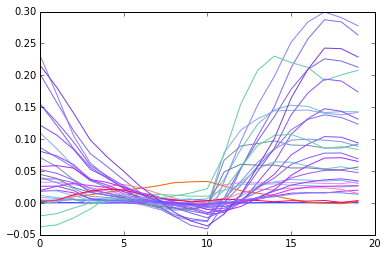

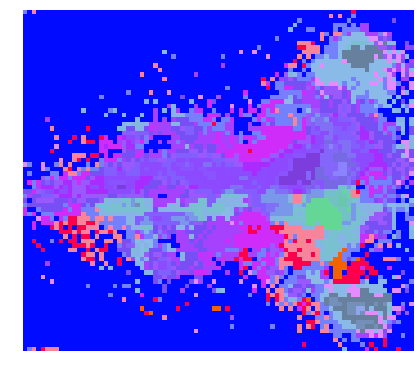

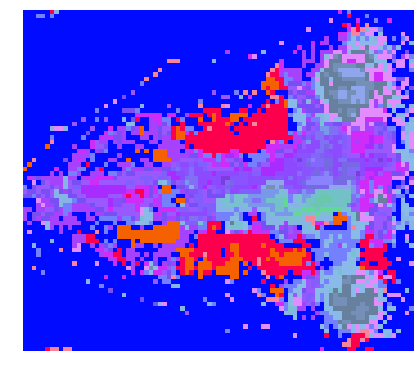

In [38]:
from numpy import arctan2, sqrt, pi, abs, dstack, clip, transpose, inf, \
    random, zeros, ones, asarray, corrcoef, allclose, maximum, add, multiply, \
    nan_to_num, copy, ndarray, around, ceil, rollaxis

# these functions below are inspired mainly from Thunder-Project source code, v.0.6
# url: https://raw.githubusercontent.com/thunder-project/thunder/branch-0.6/thunder/viz/colorize.py

# Optimal colors based on array data similarity.
def optimize_color(mat):
        mat = np.asarray(mat)

        if mat.ndim < 2:
            raise Exception('Input array must be two-dimensional')

        nclrs = mat.shape[0]

        from scipy.spatial.distance import pdist, squareform
        from scipy.optimize import minimize

        distMat = squareform(pdist(mat, metric='cosine')).flatten()

        optFunc = lambda x: 1 - np.corrcoef(distMat, squareform(pdist(x.reshape(nclrs, 3), 'cosine')).flatten())[0, 1]
        init = random.rand(nclrs*3)
        bounds = [(0, 1) for _ in range(0, nclrs * 3)]
        res = minimize(optFunc, init, bounds=bounds, method='L-BFGS-B')
        newClrs = res.x.reshape(nclrs, 3).tolist()

        from matplotlib.colors import ListedColormap

        newClrs = ListedColormap(newClrs, name='from_list')

        return newClrs

# Blend two images together using the specified operator.
def blend(img, mask, op=add):
        if mask.ndim == 3:
            for i in range(0, 3):
                img[:, :, :, i] = op(img[:, :, :, i], mask)
        else:
            for i in range(0, 3):
                img[:, :, i] = op(img[:, :, i], mask)
        return img

def _prepareMask(mask):
        mask = asarray(mask)
        mask = clip(mask, 0, inf)

        return mask / mask.max()
    
# Colorize numerical image data.
def transform(cmap, img, mask=None, mixing=1.0):
        from matplotlib.cm import get_cmap
        from matplotlib.colors import ListedColormap, LinearSegmentedColormap, hsv_to_rgb, Normalize

        img = asarray(img)
        dims = img.shape

        if cmap not in ['polar', 'angle']:

            if cmap in ['rgb', 'hv', 'hsv', 'indexed']:
                img = copy(img)
                for i, im in enumerate(img):
                    norm = Normalize(vmin=None, vmax=None, clip=True)
                    img[i] = norm(im)

            if isinstance(cmap, ListedColormap) or isinstance(cmap, str):
                norm = Normalize(vmin=None, vmax=None, clip=True)
                img = norm(copy(img))

        if mask is not None:
            mask = _prepareMask(mask)

        if isinstance(cmap, ListedColormap):
            if img.ndim == 3:
                out = cmap(img)
                out = out[:, :, :, 0:3]
            if img.ndim == 2:
                out = cmap(img)
                out = out[:, :, 0:3]
        else:
            raise Exception('Colorization method not understood')

        out = clip(out, 0, 1)

        if mask is not None:
            out = blend(out, mask, multiply)

        return clip(out, 0, 1)


# generate the better color scheme
newClrs = optimize_color(bestModel.centers)
plt.gca().set_color_cycle(newClrs.colors)
plt.plot(np.array(bestModel.centers).T);

# draw image with the new color scheme
brainmap = transform(newClrs, imgLabels[0,:,:])
draw_image(brainmap)
brainmap = transform(newClrs, imgLabels[1,:,:])
draw_image(brainmap)


### f. Improving the result by removing noise
One problem with what we've done so far is that clustering was performed on all time-series without data pre-processing. Many of  time-series objects were purely noise (e.g. those outside the brain), and some of the resulting clusters capture these noise signals. A simple trick is to perform clustering after subselecting pixels based on the standard deviation of their time series. First, let's look at a map of the standard deviation, to find a reasonable threshold that preserves most of the relavant signal, but ignores the noise.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 16

<div class="alert alert-info">

Try with different threshold of standard deviation to filter the noise. What is the "best value" that preserves most of the relavant signal, but ignores the noise ? Why ?

</div>

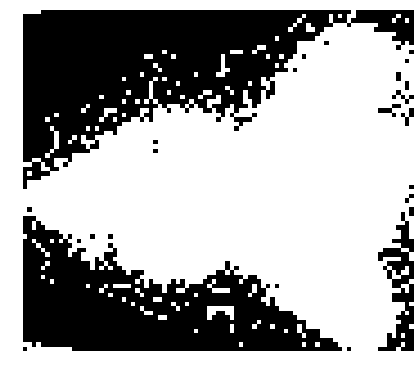

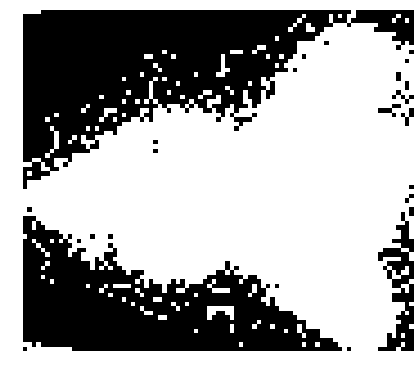

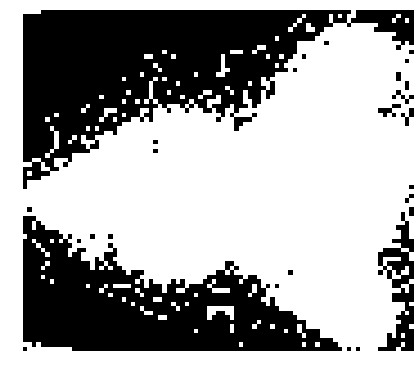

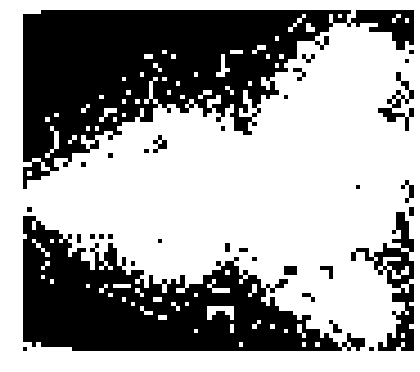

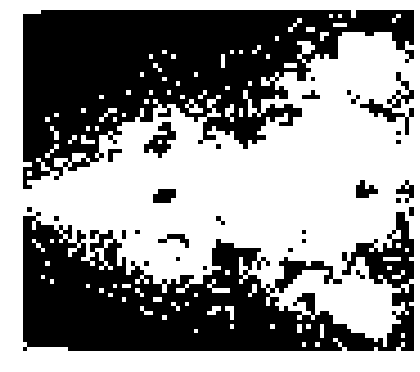

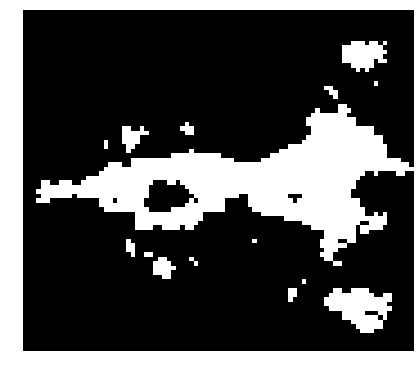

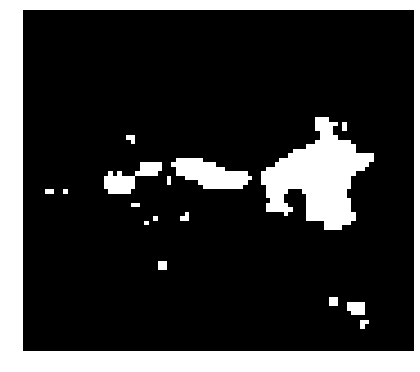

In [39]:
# calculate the standard deviation of each voxel 
# then collect to the driver
stdMap = data.map(lambda x: x.std()).toarray()

# here we should try with many different values of threshold 
# and choosing the best one
# visualize the map of the standard deviation after filtering
stds = [0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.04]
for std in stds:
    draw_image(stdMap[0,:,:] > std)

<div class="alert alert-warning">

We compare our results to this video: https://www.youtube.com/watch?v=YLVdRPVj-XM <br />
The video shows the brain activity of a zebrafish in motion.<br />
According to that, 0.007 seems like a good value that filters out noise that does not represent actual brain activity.

</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 17

<div class="alert alert-info">

Filter your data such that we only keep the voxels that have the standard deviation bigger than the threshold in question 16.

</div>

In [22]:
from numpy import std
# remove series object that has the standard deviation bigger than a threshold
filtered = data.filter(lambda x: x.std() > 0.007).cache()
print(filtered.shape)

(7146, 20)


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 18

<div class="alert alert-info">

Re-train and choose the best models with different values of `K` on the new data.

</div>

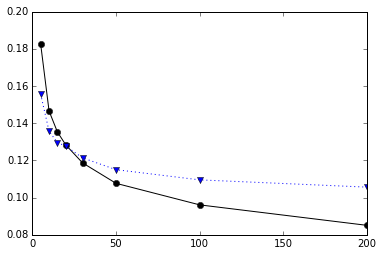

In [43]:
models = buildModels(filtered)
testAndPlotTheResult(training_data, models)

<div class="alert alert-warning">

The graph did not change much compared to last time. Therefore, we stick to our value of k=30 (elbow method)

</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 19
<div class="alert alert-info">

a) Plot the centroids of the best model with a smart color selection.  

b) Plot the result of the clustering algorithm by a color map of voxels.  

c) Comment about your figures.  
</div>

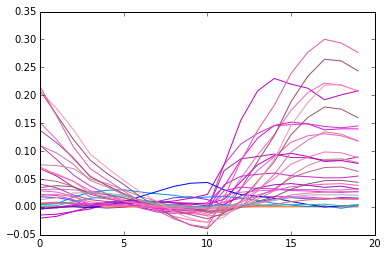

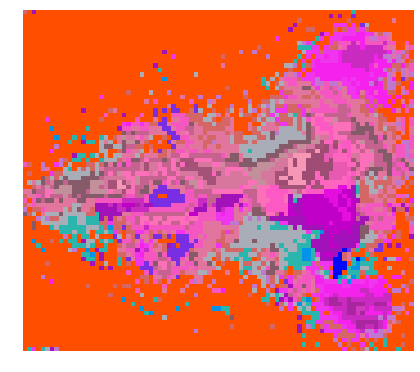

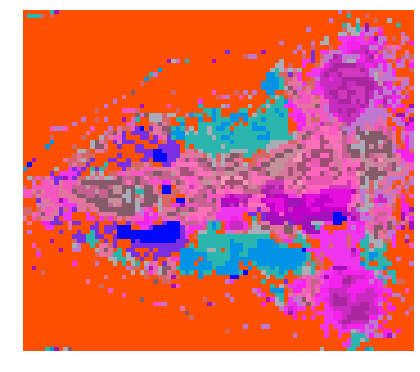

In [45]:
bestModel = models[4]
newClrs = optimize_color(bestModel.centers)

# predict the nearest cluster id for each voxel in Series
labels = bestModel.predict(training_data)

# collect data to the driver
imgLabels = np.array(labels.collect()).reshape((2, 76, 87))

# generate the better color scheme
plt.gca().set_color_cycle(newClrs.colors)
plt.plot(np.array(bestModel.centers).T);

# draw image with the new color scheme
brainmap = transform(newClrs, imgLabels[0,:,:])
draw_image(brainmap)
brainmap = transform(newClrs, imgLabels[1,:,:])
draw_image(brainmap)

<div class="alert alert-warning">

The quantization of pixels to their closest centroid values enables us to easily identify similar activity regions in the image. Similar colours correspond to similar activity series of neurons.
The purple colours correspond to voxels with high std. dev. values. Having quantized the intensity of the voxels, we find that the major brain activity of the fish takes place along the central horizontal  axis as well as on the right. This is crucial information for the domain of neurobiological research. The researcher can easily see the active regions of the brain when giving visual inputs to the fish. He can threfore analyse which regions in the brain are responsible for processing which kind of cognitive tasks.

</div>

### g. Improve the visualization by adding similarity
These maps are slightly odd because pixels that did not survive our threshold still end up colored as something. A useful trick is masking pixels based on how well they match the cluster they belong to. We can compute this using the `similarity` method of `KMeansModel`.

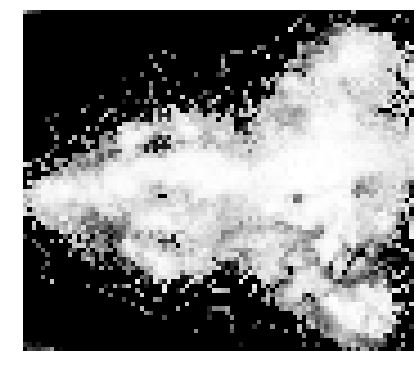

In [70]:

sim = data.map(lambda x: similarity(x, bestModel.centers))

imgSim = sim.toarray()

# draw the mask
draw_image(imgSim[0,:,:], cmap='gray', clim=(0,1))

And, it can be used as a linear mask on the colorization output

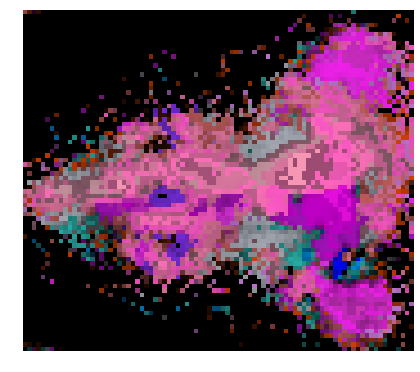

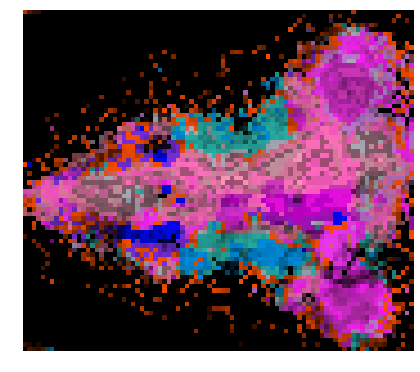

In [71]:
brainmap = transform(newClrs, imgLabels[0,:,:], mask=imgSim[0,:,:])
draw_image(brainmap)
brainmap = transform(newClrs, imgLabels[1,:,:], mask=imgSim[0,:,:])
draw_image(brainmap)

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 20

<div class="alert alert-info">

Since in the usecase we build and test the model from the same data, it can lead to overfitting problems. To avoid that, we can divide the data into training set and testing set. Note that each neuron occurs only one time in the data. So, we can not divide the data by dividing the neurons. Instead, we can divide the states of neurons into two different sets. Let's try with this approach and show the result.

</div>

In this section, we will split the data on the temporal dimension to create two equally sized sets, i.e. each split gets randomly assigned 10 out of the 20 timeframe indices. This way we are able to assign test points (10-dimensional) to training centroids (10-dimensional as well). We do not only split the set once to determine an optimal value for k. Instead, we carry out cross-validation and compute the average errors to make sure that our value of k does not depend on one particular split.<br />
We compute the errors in the following way:<br />
- Train k-Means on the training data and assign every point from the test data to its closest centroid
- Train k-Means on the test data and assign every point from the test data to its closest centroid
- Compute the sum of squared errors between the two quantized sets of test points

We average these values w.r.t. k over all the train-test-splits.

Splitting the training data into training and test set. We are carrying out cross validation on 3 different splits...

In [37]:
n_folds = 3

indices = np.arange(20)
training_indices_per_fold = []
test_indices_per_fold = []

for trial in range(n_folds):
    # split the indices
    np.random.shuffle(indices)
    training_indices = indices[:10]
    test_indices = indices[10:]

    # collect the different splits
    training_indices_per_fold.append(training_indices)
    test_indices_per_fold.append(test_indices)


Train k-Means for different k on the training as well as on the test set and compute the SSE for each split...

In [38]:
import time

# declare the possible values of K
ks = [5, 10, 15, 20, 30, 50, 75] # , 100, 125, 150, 175, 200
sq_dist_errors = []
similarity_errors = []
errors_by_split = []
    
def buildModels(data):
    # declare the collection of models
    models = []

    # build model for each K and append to models
    for k in ks:
        models.append(KMeans.train(train_split, k, maxIterations=10, initializationMode="k-means||")) 
    return models

def extract_indices(x, indices):
    return [x[idx] for idx in range(len(x)) if idx in indices]

time0 = time.time()
for i in range(len(training_indices_per_fold)):
    train_split = filtered.tordd().map(lambda x: extract_indices(x[1], training_indices_per_fold[i])).cache()
    test_split = filtered.tordd().map(lambda x: extract_indices(x[1], test_indices_per_fold[i])).cache()
    models_train = buildModels(train_split)
    models_test = buildModels(test_split)
    
    errors = []
    
    for c_idx in range(len(models_train)):
        centroids_train = models_train[c_idx].centers
        centroids_test = models_test[c_idx].centers
        predictions_train = test_split.map(lambda x: centroids_train[models_train[c_idx].predict(x)])
        predictions_test = test_split.map(lambda x: centroids_test[models_test[c_idx].predict(x)])
        predictions_combined = predictions_train.zip(predictions_test)
        
        error = predictions_combined.map(lambda x: np.linalg.norm(np.array(x[0]) - np.array(x[1]))**2) \
            .reduce(lambda x,y: x+y)
        errors.append(error)
        
    errors_by_split.append(errors)

print(time.time() - time0, "seconds")

77.13031911849976 seconds


Average the errors over the different splits and plot the results...

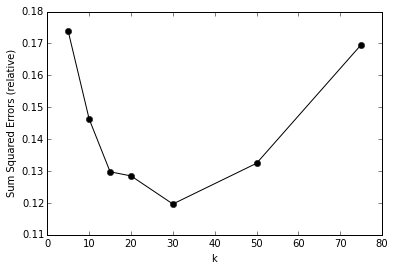

In [41]:
mean_errors = np.array(errors_by_split).mean(axis=0)

plt.plot(ks, mean_errors / mean_errors.sum(), 'k-o')
plt.ylabel('Sum Squared Errors (relative)')
plt.xlabel('k')
plt.show()

<div class="alert alert-warning">

We can clearly see that the value of k=30 produces the best similarity between predictions from a k-Means model trained on the training data and one trained on the test data when applying both of them to the test data. We therefore conclude that a value of k above 30 corresponds to a model that is overfit to the training data. A value below 30 underfits the data because points are quantized to centroids that are very distant.

</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 21

<div class="alert alert-info">

Is using K-Means the best choice for a clustering algorithm? Comment the choice and suggest alternatives. For example, look at [Mixture Models](https://en.wikipedia.org/wiki/Mixture_model) and, if you have time, propose an alternative clustering technique. 

</div>

<div class="label label-danger">NOTE</div> Mixture models will be covered in the ASI course in greater detail.

In [52]:
from sklearn.mixture import GMM

ks_rdd = sc.parallelize([5, 10, 15, 20, 30, 50, 100, 200])

# convert series data to rdd of values
training_data = data.tordd().map(lambda x: np.array(x[1])).cache()
    
def gm_buildModels(data):
    # declare the collection of models
    bData = sc.broadcast(data.collect())
    
    gm_models = ks_rdd.map(lambda k: GMM(k).fit(bData.value))

    return gm_models.collect()

gm_models = gm_buildModels(training_data)

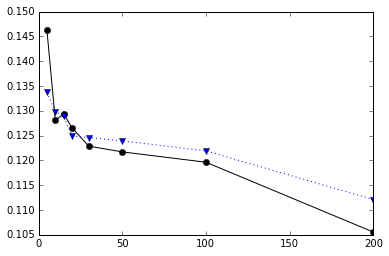

7.01329231262207 seconds


In [59]:
def gm_model_error_1Parall(bData, model):
    err = 0
    for x in bData.value:
        err += euclidean(x,model.means_[model.predict(x)])
    return err

def gm_model_error_2Parall(bData, model):
    err = 0
    for x in bData.value:
        err += similarity(x,model.means_)
    return 1. / err

def gm_testAndPlotTheResultParall(data, models):
    # compute the error metrics for the different resulting clusterings
    
    bData = sc.broadcast(data.collect())
    # errors of models when using function Sum Square Distance Error
    errors_1 = np.asarray(models.map(lambda model: gm_model_error_1Parall(bData,model)).collect())
    
    # error of models when using similarity
    errors_2 = np.asarray(models.map(lambda model: gm_model_error_2Parall(bData,model)).collect())

    # plot the errors with each value of K
    plt.plot(
        ks, errors_1 / errors_1.sum(), 'k-o',
        ks, errors_2 / errors_2.sum(), 'b:v')
    plt.show()

gm_modelsRDD = sc.parallelize(gm_models)
time0 = time.time()
gm_testAndPlotTheResultParall(training_data, gm_modelsRDD)
print(time.time() - time0, "seconds")

In [77]:
n_folds = 3

indices = np.arange(20)
training_indices_per_fold = []
test_indices_per_fold = []

for trial in range(n_folds):
    # split the indices
    np.random.shuffle(indices)
    training_indices = indices[:10]
    test_indices = indices[10:]

    # collect the different splits
    training_indices_per_fold.append(training_indices)
    test_indices_per_fold.append(test_indices)


In [78]:
import time

# declare the possible values of K
ks = [5, 10, 15, 20, 30, 50, 75, 100] # 125, 150, 175, 200
ks_rdd = sc.parallelize(ks)

sq_dist_errors = []
similarity_errors = []
errors_by_split = []

def extract_indices(x, indices):
    return [x[idx] for idx in range(len(x)) if idx in indices]

time0 = time.time()
for i in range(len(training_indices_per_fold)):
    train_split = filtered.tordd().map(lambda x: extract_indices(x[1], training_indices_per_fold[i])).cache()
    test_split = filtered.tordd().map(lambda x: extract_indices(x[1], test_indices_per_fold[i])).cache()
    models_train = gm_buildModels(train_split)
    models_test = gm_buildModels(test_split)
    
    errors = []
    
    for c_idx in range(len(models_train)):
        centroids_train = models_train[c_idx].means_
        centroids_test = models_test[c_idx].means_
        predictions_train = test_split.map(lambda x: centroids_train[models_train[c_idx].predict(x)])
        predictions_test = test_split.map(lambda x: centroids_test[models_test[c_idx].predict(x)])
        predictions_combined = predictions_train.zip(predictions_test)
        
        error = predictions_combined.map(lambda x: np.linalg.norm(np.array(x[0]) - np.array(x[1]))**2) \
            .reduce(lambda x,y: x+y)
        errors.append(error)
        
    errors_by_split.append(errors)

print(time.time() - time0, "seconds")

70.39128017425537 seconds


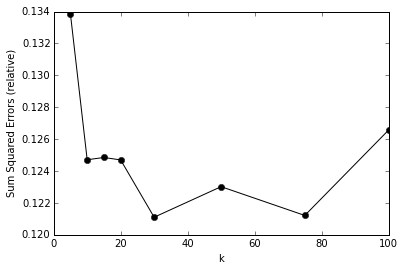

In [79]:
mean_errors = np.array(errors_by_split).mean(axis=0)

plt.plot(ks, mean_errors / mean_errors.sum(), 'k-o')
plt.ylabel('Sum Squared Errors (relative)')
plt.xlabel('k')
plt.show()

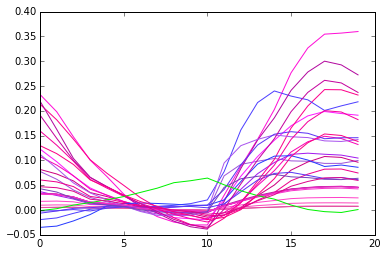

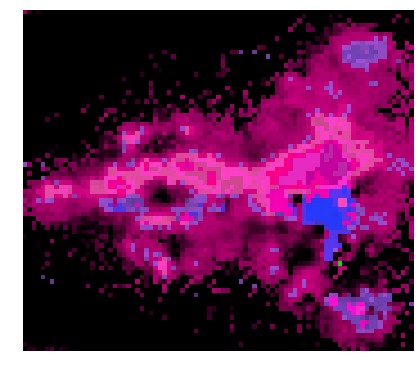

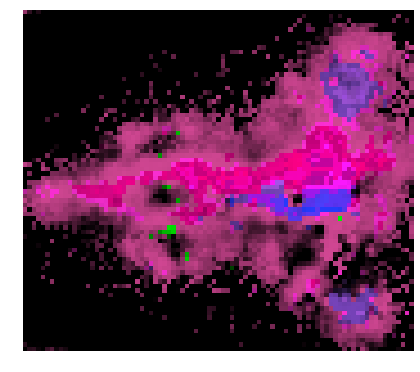

In [90]:
gm_bestModel = gm_models[4]

sim = data.map(lambda x: similarity(x, gm_bestModel.means_))

imgSim = sim.toarray()

gm_newClrs = optimize_color(gm_bestModel.means_)

# predict the nearest cluster id for each voxel in Series
gm_labels = training_data.map(lambda x: gm_bestModel.predict(x))

# collect data to the driver
gm_imgLabels = np.array(gm_labels.collect()).reshape((2, 76, 87))

# generate the better color scheme
plt.gca().set_color_cycle(gm_newClrs.colors)
plt.plot(np.array(gm_bestModel.means_).T);

# draw image with the new color scheme
gm_brainmap = transform(gm_newClrs, gm_imgLabels[0,:,:], mask=imgSim[0,:,:])
draw_image(gm_brainmap)
gm_brainmap = transform(gm_newClrs, gm_imgLabels[1,:,:], mask=imgSim[0,:,:])
draw_image(gm_brainmap)

<div class="alert alert-warning">

For the Gaussian Mixture Models we adopted the maximum parallelized version of the program to train our models, and tried cross validation to find the best k. But our results are not as satisfiying as those we got with Kmeans as the best k is not as distinguishable and the clusterinf, even with similarity filtering is pretty bad. 

</div>

## Bonus: Regression on the neurons v.s. average brain activity by spike

In this section we extended our dataset s.t. to cover 240 timestamps instead of only 20 (that we got from: https://github.com/sryza/aas/tree/master/ch11-neuro/fish-long). This way, we could analyse the spikes in the average brain activity over time. We also fit a regression model to capture the relationship between each neuron and the average brain activity in the time interval of a spike to determine which ones can be used as indicators for predicting spikes. (c.f. http://fias.uni-frankfurt.de/neuro/compneuro/upload/lectures/lec02-encoding.pdf)

In [3]:
img_long = td.images.frombinary('fish-long', engine=None).tospark(engine=sc)

<function matplotlib.pyplot.show>

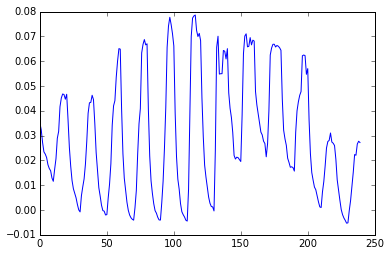

In [4]:
series = img_long.toseries().normalize()
y = series.mean()
plt.plot(y)
plt.show

We see that there are 13 spikes in the 240 timestamps. We conclude that there have been 13 stimuli that have been shown to the fish one after the other.

Now we are running a linear regression on the image samples (per timeframe) and regress them against the average brain activity of a spike. Therefore, we obtain a separate regression weight for each voxel.

In [5]:
indices = [10, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230]

/opt/conda/lib/python3.5/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


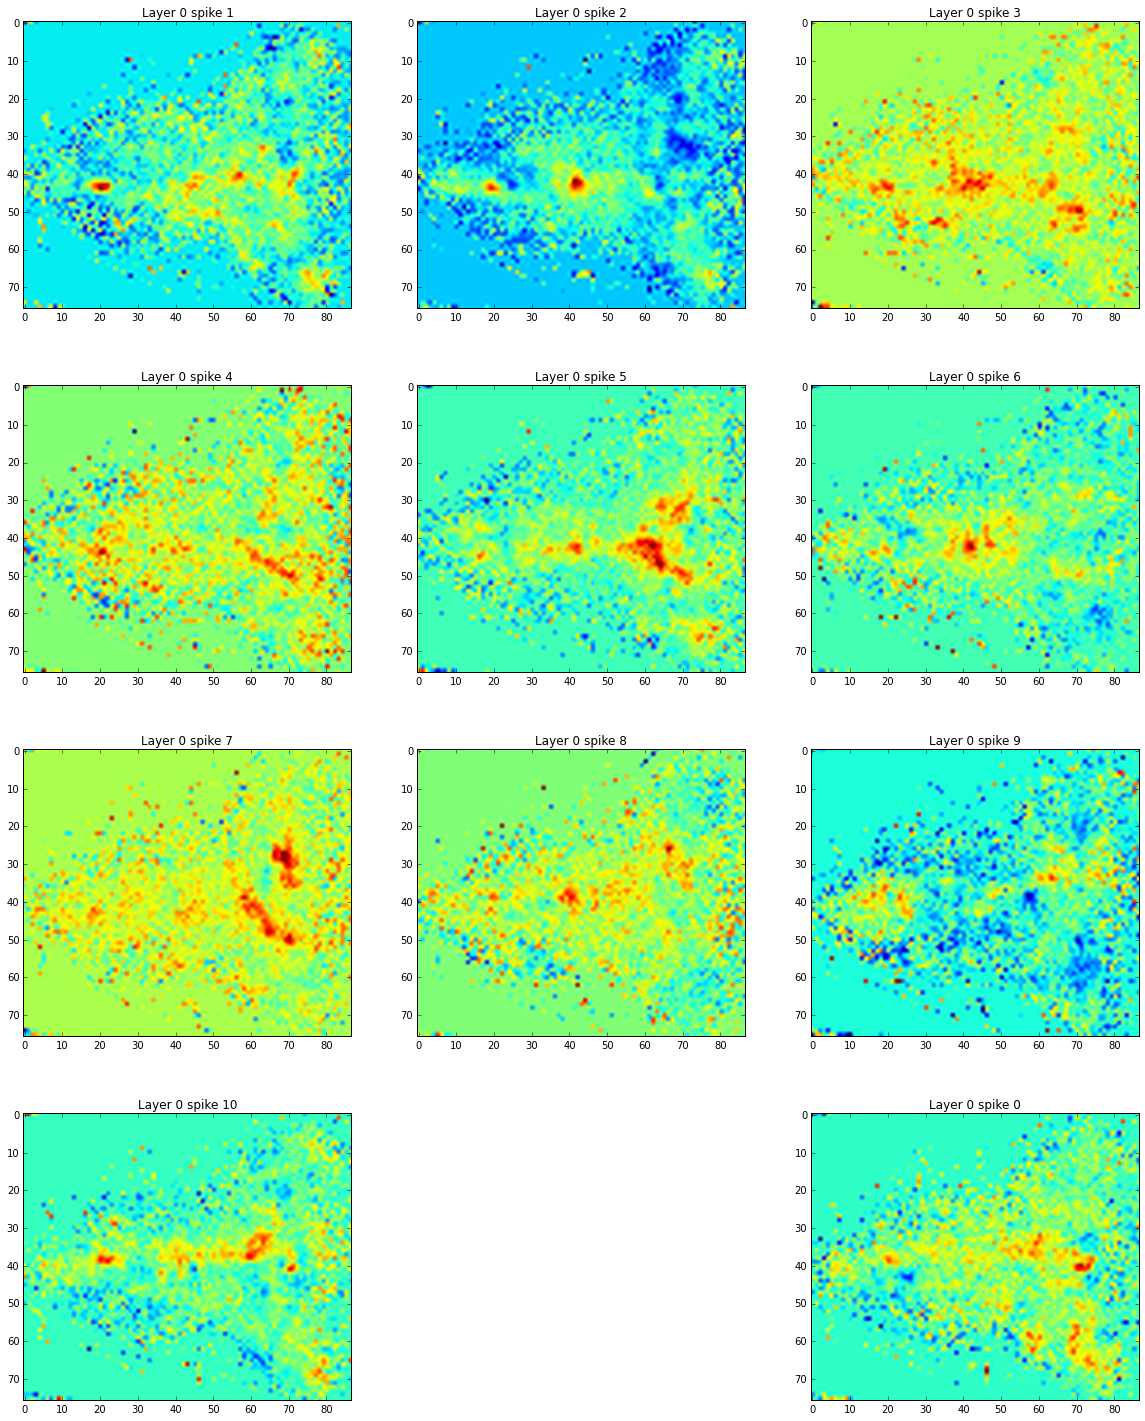

In [12]:
from regression import LinearRegression

fig = plt.figure(figsize=(20,25))
for idx in range(len(indices) - 1):
    plt.subplot(4,3,idx)
    rng = (indices[idx], indices[idx + 1])
    raw_features = series.between(rng[0],rng[1]).toarray()[0].T
    y_cur = y.between(rng[0],rng[1])
    X = np.array([raw_feature.flatten() for raw_feature in raw_features])
    algorithm = LinearRegression(fit_intercept=False)
    model = algorithm.fit(X, y_cur.toarray())
    beta_values = model.betas.toarray()[1:]
    beta_image = beta_values.reshape(76,87)
    plt.imshow(beta_image, interpolation='spline36', aspect='equal', cmap='jet')
    plt.title("Layer 0 spike " + str(idx))
plt.show()

We can see that there are some neurons having a much bigger contribution to the spikes in brain activity than others. Now we can clearly identify regions that impact each spike (red parts of each image).

# 4. Summary
We studied Thunder and its important methods to work with images, such as `Image`, `Series` and how to apply them to a use case. In the use case, we used the K-Means algorithm to cluster the neurons without prior knowledge of what a good choice of K could be. Subsequently, we introduced some techniques for improving the initially obtained results, such as removing noise and considering similarity.

# References
Some of the examples in this notebook are inspired from the [documentation of Thunder](http://docs.thunder-project.org/).